(validation:validation_experimental_data)=
# Napari-stress validation

This notebook focuses on the validation of the napari-stress implementation of the legacy code from Gross et al. ({cite}`gross2021stress`). It uses the original dataset that was used in the analysis and compares each result to the original results.

In [1]:
import napari
import numpy as np
import pandas as pd
from napari_stress import (reconstruction, measurements, utils, stress_backend,
                           plotting, frame_by_frame, TimelapseConverter)
import os
import vedo
import napari_process_points_and_surfaces as nppas

from skimage import io
import matplotlib.pyplot as plt
import seaborn as sns
from tifffile import imread

In [2]:
viewer = napari.Viewer(ndisplay=3)

## Load the data

We load the original data as follows. The analysis only takes into account the first 21 timesteps, which equivalents to 60 minutes of data. The scale of the data is `[4, 0.346, 0.346]µm³` per voxel. The interfacial tension of the used droplet is `3.3 mN/m`.


In [4]:
root  = r'C:\Users\johan\Nextcloud\Shared\Campaslab\projects\napari-stress-paper\data'
filename = os.path.join(root, '3DTimelapse-vsx0.346um-vsz4um-pinhole299um0-vst3min-16zSteps-30timeSteps-memNG-cy5Drop.lsm')
image = imread(filename)[:21]

# get number of frames
n_frames = image.shape[0]
image.shape

(21, 16, 3, 1024, 1024)

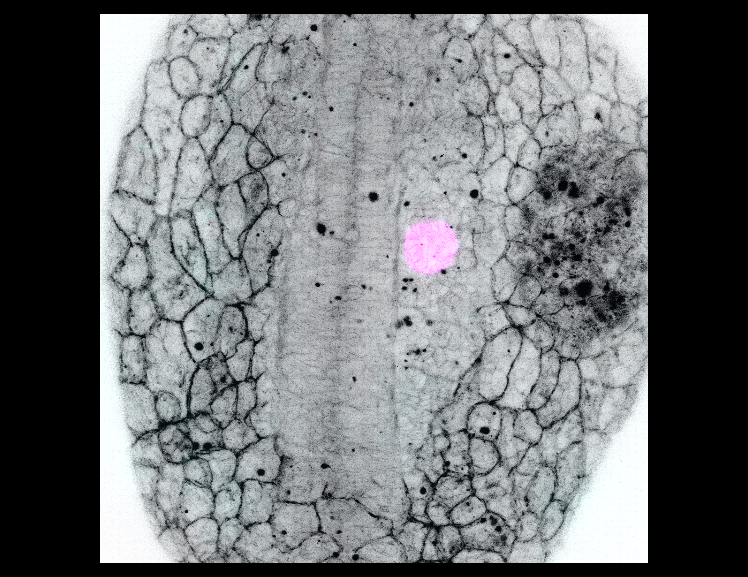

In [5]:
viewer.add_image(image[:, :, 0], name='membrane', colormap='gray_r', blending='translucent', scale=[1, 4, 0.346, 0.346])
viewer.add_image(image[:, :, 1], name='droplet', colormap='magenta', blending='additive', scale=[1, 4, 0.346, 0.346])
viewer.add_image(image[:, :, 2], name='other', colormap='cyan', blending='additive', scale=[1, 4, 0.346, 0.346])
napari.utils.nbscreenshot(viewer, canvas_only=True)

### Data dimensions
You need to set a few parameters pertaining to your data:

In [6]:
voxel_size_x = 0.346  # microns
voxel_size_y = 0.346  # microns
voxel_size_z = 3.998  # microns
target_voxel_size = 2  # microns
time_step = 3  # minutes

## Analysis

We first put all parameters into a dictionary so we can save and reload them later. The parameters are explained here:
- [Reconstruction](toolboxes:droplet_reconstruction:interactive)
- [Measurement](toolboxes:stress_toolbox:stress_toolbox_interactive)

In [7]:
reconstruction_parameters = {
    'voxelsize': np.asarray([voxel_size_z, voxel_size_y, voxel_size_x]),
    'target_voxelsize': 2,
    'smoothing_sigma': 1,
    'n_smoothing_iterations': 15,
    'n_points': 256,
    'n_tracing_iterations': 2,
    'resampling_length': 1,
    'fit_type': 'fancy',
    'edge_type': 'interior',
    'trace_length': 10,
    'sampling_distance': 0.5,
    'interpolation_method':  'cubic',
    'outlier_tolerance': 1.5,
    'remove_outliers': True,
    'return_intermediate_results': True,
    'use_dask': True}

measurement_parameters = {
    'max_degree': 20,
    'n_quadrature_points': 5810,
    'gamma': 3.3,
    'use_dask': True}

We run the reconstruction and the stress analysis:

In [8]:
results_reconstruction = reconstruction.reconstruct_droplet(image[:, :, 1], **reconstruction_parameters)

Dask client up and running <Client: 'tcp://127.0.0.1:62892' processes=4 threads=4, memory=31.96 GiB>  Log: http://127.0.0.1:8787/status


In [9]:
_ = stress_backend.lbdv_info(Max_SPH_Deg=measurement_parameters['max_degree'],
                             Num_Quad_Pts=measurement_parameters['n_quadrature_points'])

results_stress_analysis = measurements.comprehensive_analysis(results_reconstruction[2][0], **measurement_parameters)

Dask client already running <Client: 'tcp://127.0.0.1:62892' processes=4 threads=4, memory=31.96 GiB>  Log: http://127.0.0.1:8787/status


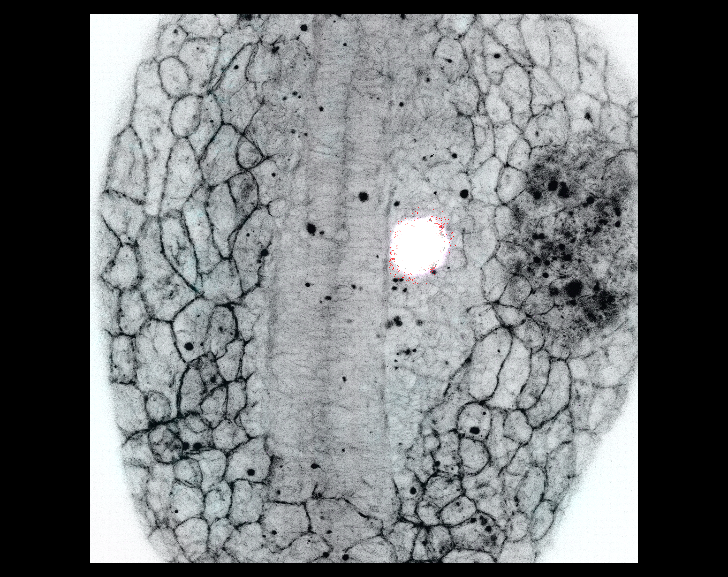

In [26]:
for res in results_reconstruction + results_stress_analysis:
    layer = napari.layers.Layer.create(res[0], res[1], res[2])
    viewer.add_layer(layer)
napari.utils.nbscreenshot(viewer, canvas_only=True)

## Create paper screenshots and figures

In [ ]:
viewer.layers['membrane'].depiction = 'volume'
viewer.layers['droplet'].depiction = 'volume'
viewer.layers['droplet'].blending = 'additive'
viewer.layers['other'].visible = False

We move the rendered plane to the center of mass of the droplet:

In [22]:
figure_directory = r'C:\Users\johan\Nextcloud\Shared\Campaslab\projects\napari-stress-paper\documents\manuscript\figures\Figure7\imgs'
os.path.exists(figure_directory)

True

## Views on data

In [11]:
def set_timepoint(viewer, current_timepoint):
    # taken from https://github.com/haesleinhuepf/napari-time-slicer/blob/main/src/napari_time_slicer/_function.py
    variable_timepoint = list(viewer.dims.current_step)
    variable_timepoint[0] = current_timepoint
    viewer.dims.current_step = variable_timepoint

def make_layers_invisible(viewer):
    for layer in viewer.layers:
        layer.visible = False

In [12]:
timepoint = 10
set_timepoint(viewer, timepoint)
figure_quality = 4

In [13]:
viewer.dims.current_step

(10, 7, 511, 511)

## Reconstruction workflow

### 3D overview figure

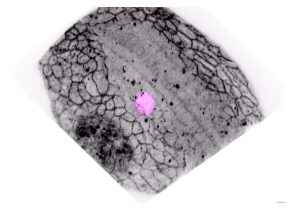

In [ ]:
make_layers_invisible(viewer)

viewer.window.resize(1400, 800)
viewer.layers['membrane'].visible = True
viewer.layers['membrane'].depiction='volume'
viewer.layers['membrane'].blending = 'translucent'
viewer.layers['membrane'].rendering = 'mip'
viewer.layers['droplet'].visible = True
viewer.layers['droplet'].depiction='volume'
viewer.layers['droplet'].blending = 'additive'
viewer.layers['droplet'].rendering = 'mip'
viewer.camera.center = (36.0, 148.0, 210.0)
viewer.camera.zoom = 2
viewer.camera.angles = (-145, 26, 66)

viewer.scale_bar.visible = True

screenshot = viewer.screenshot(scale=figure_quality)

fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(screenshot)
ax.axis('off')
fig.savefig(os.path.join(figure_directory, 'droplet_membranes_3D.png'), dpi=300, bbox_inches='tight')

### 2D closeup

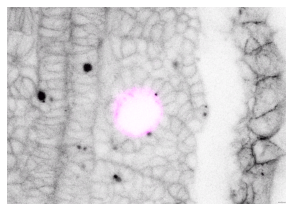

In [ ]:
CoM_droplet = viewer.layers['Center'].data[:, 1:][0]

viewer.window.resize(1400, 800)
viewer.layers['droplet'].depiction = "plane"
viewer.layers['membrane'].depiction = 'plane'
viewer.layers['membrane'].plane.position = CoM_droplet/ viewer.layers['membrane'].scale[1:]
viewer.layers['droplet'].plane.position = CoM_droplet/ viewer.layers['droplet'].scale[1:]

viewer.camera.center = (0, 145, 220)
viewer.camera.zoom = 5
viewer.camera.angles = (0, 0, 90)

screenshot = viewer.screenshot(scale=figure_quality)

fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(screenshot)
ax.axis('off')
fig.savefig(os.path.join(figure_directory, 'droplet_membranes_2D.png'), dpi=300, bbox_inches='tight')

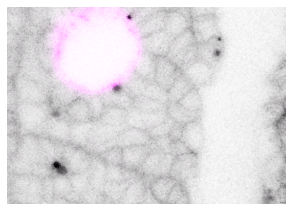

In [ ]:
viewer.dims.ndisplay = 3
viewer.window.resize(1400, 800)
viewer.camera.center = (0, 173, 234)
viewer.camera.zoom = 9
viewer.camera.angles = (0, 0, 90)

viewer.layers['membrane'].blending = 'translucent'
viewer.layers['membrane'].depicion = 'plane'

screenshot = viewer.screenshot(scale=figure_quality)
fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(screenshot)
ax.axis('off')
fig.savefig(os.path.join(figure_directory, 'droplet_membranes_2D_2D.png'), dpi=300, bbox_inches='tight')

### Label image

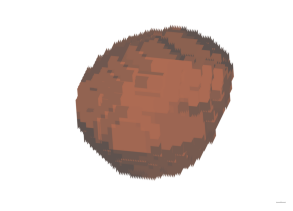

In [ ]:
make_layers_invisible(viewer)
viewer.layers['Label image'].visible = True

viewer.window.resize(1400, 800)
viewer.camera.center = (22, 162, 195)
viewer.camera.zoom = 16
viewer.camera.angles = (-116, 53, -25)

screenshot = viewer.screenshot(scale=figure_quality)

fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(screenshot)
ax.axis('off')
fig.savefig(os.path.join(figure_directory, 'droplet_label.png'), dpi=300, bbox_inches='tight')


### First guess

In [ ]:
make_layers_invisible(viewer)
surface = frame_by_frame(nppas.largest_label_to_surface)(viewer.layers['Label image'].data)
surface_smooth = frame_by_frame(nppas.smooth_surface)(surface, 15)
surface_decimated = frame_by_frame(nppas.decimate_quadric)(surface_smooth, number_of_vertices=256)
viewer.add_points(surface_decimated[0], size=0.2, name='droplet surface points', scale=[1, 2, 2, 2])
viewer.add_surface(surface_decimated, name='droplet surface', scale=[1, 2, 2, 2])

In [ ]:
from napari_threedee.utils.napari_utils import get_dims_displayed
layer = viewer.layers['droplet surface']
view_direction = np.asarray(viewer.camera.view_direction)
dims_displayed = get_dims_displayed(layer)
layer_view_direction = np.asarray(layer._world_to_data_ray(view_direction))[dims_displayed]

visual = viewer.window._qt_window._qt_viewer.layer_to_visual[layer]
visual.node.shading_filter.light_dir = layer_view_direction[::-1]
layer.refresh()

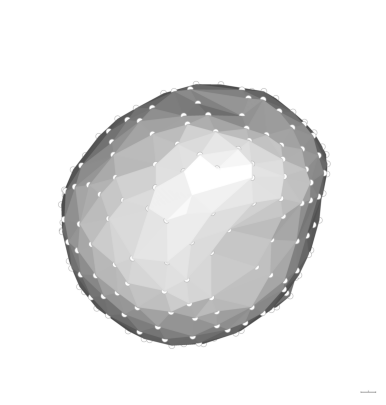

In [ ]:
make_layers_invisible(viewer)
viewer.window.resize(1400, 800)
viewer.layers['droplet surface'].visible = True
viewer.layers['droplet surface points'].visible = True

screenshot = viewer.screenshot(scale=figure_quality)
fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(screenshot)
ax.axis('off')
fig.savefig(os.path.join(figure_directory, 'droplet_first_guess.png'), dpi=300, bbox_inches='tight')

### Trace vectors

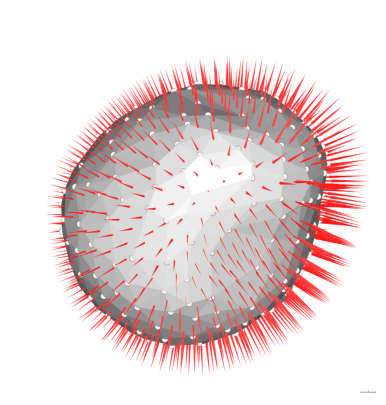

In [ ]:
viewer.window.resize(1400, 800)
viewer.layers['Normals'].visible = True
viewer.layers['Normals'].edge_width = 0.2
viewer.layers['Normals'].length = 0.7
viewer.layers['Normals'].vector_style = 'arrow'

screenshot = viewer.screenshot(scale=figure_quality)
fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(screenshot)
ax.axis('off')
fig.savefig(os.path.join(figure_directory, 'droplet_normals.png'), dpi=300, bbox_inches='tight')

### Reconstruction

In [ ]:
make_layers_invisible(viewer)
viewer.window.resize(1400, 800)
viewer.layers['droplet'].visible = True
viewer.layers['droplet'].depiction = 'volume'
viewer.layers['Droplet pointcloud (smoothed)'].visible = True
viewer.layers['droplet'].blending = 'translucent'
viewer.layers['droplet'].colormap = 'I Purple'

viewer.camera.center = (35, 155, 207)
viewer.camera.angles = (-50, 51, 87)

screenshot = viewer.screenshot(scale=figure_quality)
fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(screenshot)
ax.axis('off')
fig.savefig(os.path.join(figure_directory, 'droplet_refined.png'), dpi=300, bbox_inches='tight')

#### Total stress

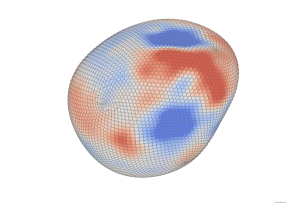

In [ ]:
viewer.camera.angles = (-116, 53, -25)
viewer.camera.zoom = 18
viewer.camera.center = (29.15186330844246, 153.74747080708815, 208.32406186131644)

make_layers_invisible(viewer)
viewer.window.resize(1400, 800)
viewer.layers['droplet'].blending = 'translucent'
viewer.layers['membrane'].visible = False
viewer.layers['Result of lebedev quadrature (droplet)'].visible = True
viewer.layers['Result of lebedev quadrature on ellipsoid'].visible = False

viewer.layers['Result of lebedev quadrature (droplet)'].blending = 'opaque'
viewer.layers['Result of lebedev quadrature (droplet)'].face_color = 'stress_total'
viewer.layers['Result of lebedev quadrature (droplet)'].face_colormap = 'coolwarm'
viewer.layers['Result of lebedev quadrature (droplet)'].face_contrast_limits = [-0.35, 0.35]
viewer.layers['Result of lebedev quadrature (droplet)'].refresh()
viewer.layers['Result of lebedev quadrature (droplet)'].size = 1

screenshot_total_stress = viewer.screenshot(scale=figure_quality)
fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(screenshot_total_stress)
ax.axis('off')
fig.savefig(os.path.join(figure_directory, "stress_total.png"), dpi=300, bbox_inches='tight')

#### Cell stress

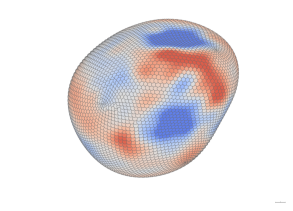

In [ ]:
viewer.layers['Result of lebedev quadrature (droplet)'].face_color = 'stress_cell'
viewer.layers['Result of lebedev quadrature (droplet)'].face_colormap = 'coolwarm'
viewer.layers['Result of lebedev quadrature (droplet)'].blending = 'opaque'
viewer.layers['Result of lebedev quadrature (droplet)'].face_contrast_limits = [-0.35, 0.35]
viewer.layers['Result of lebedev quadrature (droplet)'].refresh()
viewer.layers['Result of lebedev quadrature (droplet)'].size = 1
viewer.window.resize(1400, 800)

screenshot_cell_stress = viewer.screenshot(scale=figure_quality)
fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(screenshot_cell_stress)
ax.axis('off')
fig.savefig(os.path.join(figure_directory, "stress_cell.png"), dpi=300, bbox_inches='tight')

#### Tissue stress

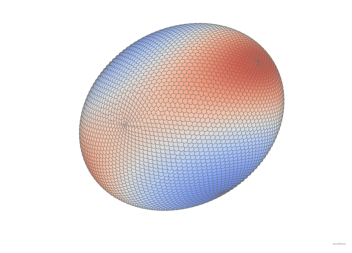

In [ ]:
viewer.layers['Result of lebedev quadrature (droplet)'].visible = False
viewer.layers['Result of lebedev quadrature on ellipsoid'].visible = True
viewer.layers['Result of lebedev quadrature on ellipsoid'].face_color = 'stress_tissue'
viewer.layers['Result of lebedev quadrature on ellipsoid'].face_colormap = 'coolwarm'
viewer.layers['Result of lebedev quadrature on ellipsoid'].blending = 'opaque'
viewer.layers['Result of lebedev quadrature on ellipsoid'].face_contrast_limits = [-0.1, 0.1]
viewer.layers['Result of lebedev quadrature on ellipsoid'].refresh()
viewer.layers['Result of lebedev quadrature on ellipsoid'].size = 1
viewer.window.resize(1400, 800)

screenshot_tissue_stress = viewer.screenshot(scale=figure_quality)
fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(screenshot_tissue_stress)
ax.axis('off')
fig.tight_layout()
fig.savefig(os.path.join(figure_directory, "stress_tissue.png"), dpi=300, bbox_inches='tight')

### Extremal stress 3D

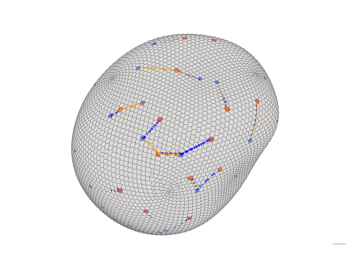

In [ ]:
viewer.window.resize(1400, 800)
viewer.camera.center = (35, 155, 207)
viewer.camera.angles = (-70, 30, 16)
viewer.layers['Result of lebedev quadrature (droplet)'].visible = True
viewer.layers['Result of lebedev quadrature on ellipsoid'].visible = False
viewer.layers['Result of lebedev quadrature (droplet)'].size = 1

viewer.layers['Total stress: Geodesics maxima -> nearest minima'].visible = True
viewer.layers['Total stress: Geodesics maxima -> nearest minima'].edge_width = 0.8
viewer.layers['Total stress: Geodesics maxima -> nearest minima'].blending = 'opaque'
viewer.layers['Total stress: Geodesics minima -> nearest maxima'].visible = True
viewer.layers['Total stress: Geodesics minima -> nearest maxima'].edge_width = 0.8
viewer.layers['Total stress: Geodesics minima -> nearest maxima'].blending = 'opaque'
viewer.layers['Result of lebedev quadrature (droplet)'].face_color = 'stress_total_extrema'
viewer.layers['Result of lebedev quadrature (droplet)'].blending = 'opaque'
viewer.layers['Result of lebedev quadrature (droplet)'].face_colormap = 'coolwarm'
viewer.layers['Result of lebedev quadrature (droplet)'].face_contrast_limits = [-1, 1]
viewer.layers['Result of lebedev quadrature (droplet)'].refresh()

screenshot_nearest_extrema_3d = viewer.screenshot(scale=figure_quality)
fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(screenshot_nearest_extrema_3d)
ax.axis('off')
fig.tight_layout()
fig.savefig(os.path.join(figure_directory, "droplet_nearest_extrema_3d.png"), dpi=300)

## Advanced visualizations

In this section, we create some advanced visualizations to highlight the interplay between the obtained measurements and their biological relevance.

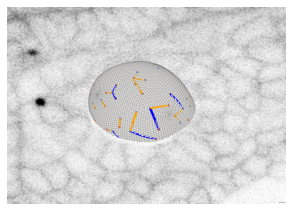

In [ ]:
set_timepoint(viewer, 4)
viewer.camera.center = (35,147,209)
viewer.camera.angles = (-57, 40, 112)
viewer.camera.zoom = 11

viewer.layers['membrane'].visible = True
viewer.layers['membrane'].plane.position = (7.5, 443, 697)
viewer.layers['membrane'].rendering = 'additive'
viewer.layers['Result of lebedev quadrature (droplet)'].visible = True
viewer.layers['Result of lebedev quadrature on ellipsoid'].visible = False
viewer.layers['Result of lebedev quadrature (droplet)'].size = 1

viewer.layers['Total stress: Geodesics maxima -> nearest minima'].visible = True
viewer.layers['Total stress: Geodesics maxima -> nearest minima'].vector_style = 'line'
viewer.layers['Total stress: Geodesics maxima -> nearest minima'].edge_width = 0.8
viewer.layers['Total stress: Geodesics minima -> nearest maxima'].visible = True
viewer.layers['Total stress: Geodesics minima -> nearest maxima'].edge_width = 0.8
viewer.layers['Total stress: Geodesics minima -> nearest maxima'].vector_style = 'line'
viewer.layers['Result of lebedev quadrature (droplet)'].face_color = 'stress_total_extrema'
viewer.layers['Result of lebedev quadrature (droplet)'].face_colormap = 'coolwarm'
viewer.layers['Result of lebedev quadrature (droplet)'].face_contrast_limits = [-1, 1]
viewer.layers['Result of lebedev quadrature (droplet)'].refresh()

screenshot_nearest_extrema_3d = viewer.screenshot(scale=figure_quality)

fig, ax = plt.subplots(figsize=(5,5))
ax.axis('off')
ax.imshow(screenshot_nearest_extrema_3d)
fig.savefig(os.path.join(figure_directory, "droplet_membrane_nearest_extrema_3d.png"), dpi=300, bbox_inches='tight')

### Make intersection of droplet and viewing plane

In [ ]:
Converter = TimelapseConverter()
surfaces = Converter.data_to_list_of_data(viewer.layers['stress_autocorrelations'].data,
                                          layertype='napari.types.SurfaceData')
df = viewer.layers['Result of lebedev quadrature (droplet)'].features

slice_center = CoM_droplet + np.asarray([2, 0, 0])
meshes = [vedo.Mesh((surf[0], surf[1])) for surf in surfaces]
intersection = [mesh.intersect_with_plane(origin = slice_center) for mesh in meshes]
points = [inters.points() for inters in intersection]

# order points (z, y, x) clockwise with respect to (1, 0, 0) axis
points_centered = [pt - CoM_droplet for pt in points]
angles = [np.arctan2(pt[:, 1], pt[:, 2]) for pt in points_centered]
points_ordered = [pt[np.argsort(ang)] for pt, ang in zip(points, angles)]

# append first point to the end of each array
points_ordered = [np.append(pt, pt[0][None, :], axis=0) for pt in points_ordered]

# calculate vectors between points
vectors_between_points = [np.diff(pt, axis=0) for pt in points_ordered]

# stack all points and vectors together into shape (n_points, 2, 3)
vectors = []
stresses = []
for i, (pts, vecs, (frame, group)) in enumerate(zip(points_ordered, vectors_between_points, df.groupby('frame'))):
    
    _pts = np.insert(pts, 0, np.ones(len(pts))*i, axis=1)
    _vecs = np.insert(vecs, 0, np.ones(len(vecs))*i, axis=1)

    vectors.append(np.stack([_pts[:-1], _vecs], axis=1))

    # find nearest vertex on pointcloud and retrieve feature
    closest_points = [meshes[i].closest_point(pt, return_point_id=True) for pt in pts]
    stresses += list(group['stress_total'].values[closest_points][:-1])

    
vectors4d = np.concatenate(vectors, axis=0)
viewer.add_vectors(vectors4d, name='stress_outline_path', features={'stress': stresses}, edge_color='stress', edge_colormap='coolwarm', edge_contrast_limits=[-0.1, 0.1], edge_width=1, opacity=1)

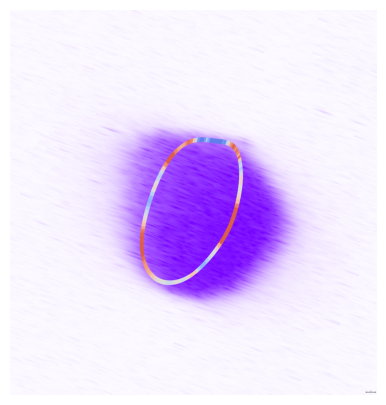

In [ ]:
make_layers_invisible(viewer)
set_timepoint(viewer, 10)
viewer.window.resize(1400, 800)
viewer.camera.center = (24, 148, 201)
viewer.camera.zoom = 10.5
viewer.camera.angles = (-20, -57, 90)

viewer.layers['droplet'].visible = True
viewer.layers['droplet'].blending = 'minimum'
viewer.layers['droplet'].rendering = 'mip'
viewer.layers['droplet'].depiction = "volume"
viewer.layers['membrane'].visible = False
viewer.layers['stress_outline_path'].visible = True
viewer.layers['stress_outline_path'].vector_style = 'line'

viewer.layers['membrane'].plane.position = slice_center/ viewer.layers['membrane'].scale[1:]
viewer.layers['droplet'].plane.position = slice_center/ viewer.layers['droplet'].scale[1:]

screenshot = viewer.screenshot(scale=figure_quality)
fig, ax = plt.subplots(figsize=(5,5))
ax.axis('off')
ax.imshow(screenshot)
fig.savefig(os.path.join(figure_directory, "in_plane_total_stress_outline_droplet.png"), dpi=300, bbox_inches='tight')

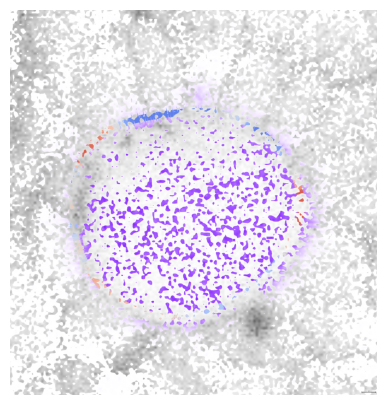

In [ ]:
make_layers_invisible(viewer)
set_timepoint(viewer, 19)
viewer.window.resize(1400, 800)
viewer.camera.angles = (0,0, 90)
viewer.camera.center = (31, 147, 212)
viewer.camera.zoom=15

viewer.layers['membrane'].visible = True
viewer.layers['droplet'].visible = True
viewer.layers['droplet'].blending = 'minimum'
viewer.layers['droplet'].rendering = 'mip'
viewer.layers['stress_outline_path'].visible = True
viewer.layers['stress_outline_path'].vector_style = 'line'
viewer.layers['stress_outline_path'].blending='translucent_no_depth'

viewer.layers['droplet'].depiction = "plane"
viewer.layers['droplet'].blending = 'translucent'
viewer.layers['droplet'].rendering = 'additive'
viewer.layers['membrane'].depiction = 'plane'
viewer.layers['membrane'].plane.position = slice_center/ viewer.layers['membrane'].scale[1:]
viewer.layers['droplet'].plane.position = slice_center/ viewer.layers['droplet'].scale[1:]

screenshot = viewer.screenshot(scale=figure_quality)
fig, ax = plt.subplots(figsize=(5,5))
ax.axis('off')
ax.imshow(screenshot)
fig.savefig(os.path.join(figure_directory, "in_plane_total_stress_outline_membrane.png"), dpi=300, bbox_inches='tight')

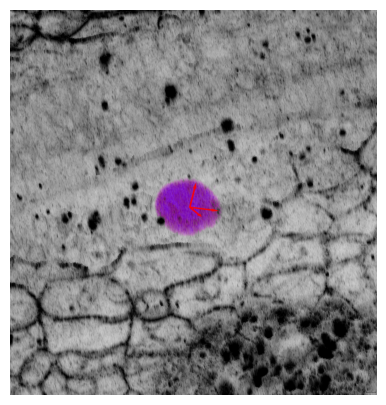

In [ ]:
make_layers_invisible(viewer)
viewer.layers['membrane'].visible = True
viewer.layers['membrane'].depiction='volume'
viewer.layers['membrane'].blending = 'translucent'
viewer.layers['membrane'].rendering = 'mip'
viewer.layers['droplet'].visible = True
viewer.layers['droplet'].depiction='volume'
viewer.layers['droplet'].blending = 'minimum'
viewer.layers['droplet'].rendering = 'mip'

viewer.layers['membrane'].visible = True
viewer.layers['droplet'].visible = True
viewer.layers['membrane'].depiction = 'volume'
viewer.layers['droplet'].depiction = 'volume'
viewer.layers['fit_ellipsoid_to_pointcloud result'].visible = True
viewer.layers['fit_ellipsoid_to_pointcloud result'].vector_style = 'arrow'
viewer.layers['fit_ellipsoid_to_pointcloud result'].edge_width = 1.0
viewer.layers['fit_ellipsoid_to_pointcloud result'].blending = 'translucent_no_depth'

viewer.window.resize(1400, 800)
viewer.camera.center=(35.0, 147.0, 209.0)
viewer.camera.zoom=4
viewer.camera.angles=(-64.56521800938883, 31.49268860197681, 98.06097255964103)

screenshot = viewer.screenshot(scale=figure_quality)
fig, ax = plt.subplots(figsize=(5,5))
ax.axis('off')
ax.imshow(screenshot)
fig.savefig(os.path.join(figure_directory, "major_axess_orientation.png"), dpi=300, bbox_inches='tight')

## Plots

In this section, we produce the plots for the figure in the paper that compare key results between the two implementations, namely: The total/cellular/tissue stresses, the spatial autocorrelations 

In [23]:
# Compile data
df_over_time, df_nearest_pairs, df_all_pairs, df_autocorrelations = utils.compile_data_from_layers(
    results_stress_analysis, n_frames=n_frames, time_step=time_step)

In [22]:
%%capture
figures_dict = plotting.create_all_stress_plots(
    results_stress_analysis,
    time_step=time_step,
    n_frames=n_frames
)

## Quantitative plots

In this section we create some quantitiative plots which demonstrate the match between the two implementations. Most noteably, we compare the total, cellular and tissue stress anisotropies as well as the spatial autocorrelation of the total stress.

In [24]:
max_time = (image[:, :, 1].shape[0] - 1) * time_step
ylims_stress = [0.1, 0.55]

In [27]:
drop = viewer.layers['Result of lebedev quadrature on ellipsoid'].data
center = [drop[drop[:,0] == t].mean(axis=0) for t in np.arange(n_frames)]
radius = np.mean([np.sqrt(((drop[drop[:,0] == t] - center[t])**2).sum(axis=1)).mean() for t in np.arange(n_frames)])

## Stress anisotropies:

For total, cell & tissue stress, the Matlab-based implementation yields the following results:

![](./imgs/total_stress_anisotropy.jpg)
![](./imgs/cell_stress_anisotropy.jpg)
![](./imgs/tissue_stress_anisotropy.jpg)

...and these are the result of the napari-stress based implementation (note the different axis limits). As you can see, the results are very similar down to the second decimal place (~10kPa).

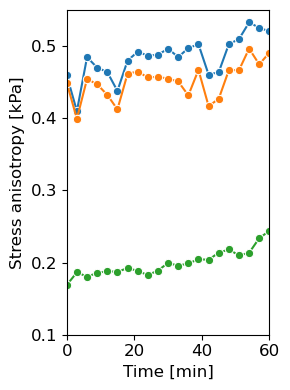

In [28]:
fig, ax = plt.subplots(figsize=(3, 4))
sns.lineplot(data=df_over_time, x='time', y='stress_total_anisotropy', ax=ax,
             markers=True, dashes=False, marker='o')
sns.lineplot(data=df_over_time, x='time', y='stress_cell_anisotropy', ax=ax,
             markers=True, dashes=False, marker='o')
sns.lineplot(data=df_over_time, x='time', y='stress_tissue_anisotropy', ax=ax,
             markers=True, dashes=False, marker='o')

ax.set_xlim([0,  max_time])
ax.set_xlabel("Time [min]", fontsize=12)
ax.set_ylim(ylims_stress)
ax.set_ylabel("Stress anisotropy [kPa]", fontsize=12)

# set fontsize of ticks
ax.tick_params(axis='both', which='major', labelsize=12)

fig.tight_layout()
fig.savefig(
    os.path.join(figure_directory, 'droplet_stress_anisotropy_all_over_time.png'),
    dpi=300,
    bbox_inches='tight')

## Spatial autocorrelations

The spatial autocorrelations for total and cellular stresses are reported as follows using the Matlab-based implementation:

![](./imgs/spatial_autocorrelation.jpg)

...and the napari-stress based implementation yields the following result for the total stress:

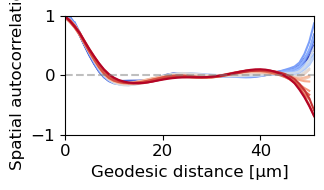

In [29]:
fig, ax = plt.subplots(figsize=(3.5, 2))

sns.lineplot(data=df_autocorrelations, x='distances', y='autocorrelations_spatial_total',
             hue='time', ax=ax, palette='coolwarm', legend=False)

ax.set_xlabel("Geodesic distance [µm]", fontsize=12)
ax.set_ylabel("Spatial autocorrelation", fontsize=12)

ax.set_xlim([0,  df_autocorrelations['distances'].max()])
ax.set_ylim([-1, 1])
ax.hlines(0, 0, df_autocorrelations['distances'].max(), linestyle='--', color='gray',
          alpha=0.5)

ax.tick_params(axis='both', which='major', labelsize=12)

fig.tight_layout()
fig.savefig(
    os.path.join(figure_directory, 'droplet_spatial_autocorrelation_total.png'),
    dpi=300,
)

and the following result for the cellular stress:

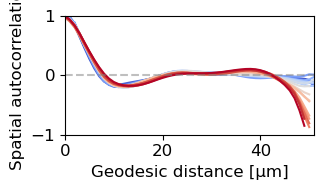

In [30]:
fig, ax = plt.subplots(figsize=(3.5, 2))

sns.lineplot(data=df_autocorrelations, x='distances', y='autocorrelations_spatial_cell',
             hue='time', ax=ax, palette='coolwarm', legend=False)

ax.set_xlabel("Geodesic distance [µm]", fontsize=12)
ax.set_ylabel("Spatial autocorrelation", fontsize=12)

ax.set_xlim([0,  df_autocorrelations['distances'].max()])
ax.set_ylim([-1, 1])
ax.hlines(0, 0, df_autocorrelations['distances'].max(), linestyle='--', color='gray',
          alpha=0.5)

ax.tick_params(axis='both', which='major', labelsize=12)

fig.tight_layout()
fig.savefig(
    os.path.join(figure_directory, 'droplet_spatial_autocorrelation_cell.png'),
    dpi=300,
)

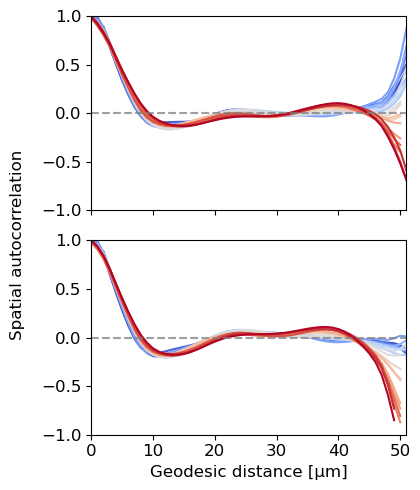

In [31]:
fig, axes = plt.subplots(ncols=1, nrows=2, figsize=(4, 5), sharex=True)

sns.lineplot(data=df_autocorrelations, x='distances', y='autocorrelations_spatial_total',
             hue='time', ax=axes[0], palette='coolwarm', legend=False)
sns.lineplot(data=df_autocorrelations, x='distances', y='autocorrelations_spatial_cell',
             hue='time', ax=axes[1], palette='coolwarm', legend=False)


for ax in axes:
    ax.set_xlim([0,  df_autocorrelations['distances'].max()])
    ax.set_ylim([-1, 1])
    ax.hlines(0, 0, df_autocorrelations['distances'].max(), linestyle='--', color='gray',
                alpha=0.5)
    ax.hlines(0, 0, df_autocorrelations['distances'].max(), linestyle='--', color='gray',
                alpha=0.5)
    ax.tick_params(axis='both', which='major', labelsize=12)


axes[1].set_xlabel("Geodesic distance [µm]", fontsize=12)
axes[0].set_ylabel("Spatial autocorrelation", fontsize=12)

# turn off x-axis and xlabel for top plot
axes[0].xaxis.set_tick_params(labelbottom=False)
axes[0].set_xlabel('')

# Use one y-label for both plots
fig.text(-0.04, 0.5, 'Spatial autocorrelation', va='center', rotation='vertical', fontsize=12)
axes[0].set_ylabel('')
axes[1].set_ylabel('')

fig.tight_layout()
fig.savefig(
    os.path.join(figure_directory, 'droplet_spatial_autocorrelation_total_cell.png'),
    dpi=300,
)

## Geodesic distances

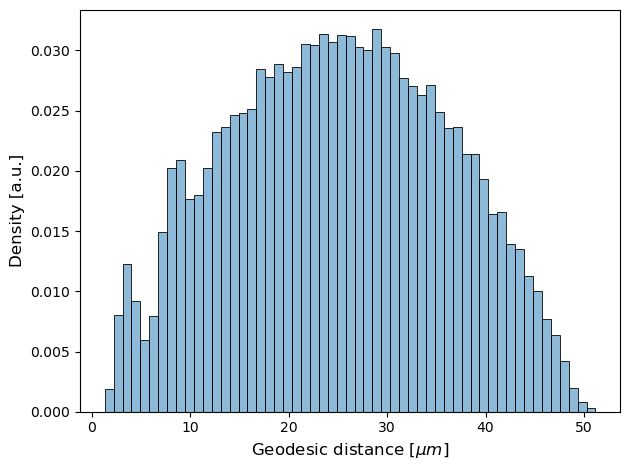

In [32]:
fig, ax = plt.subplots()
sns.histplot(data=df_all_pairs, x='stress_cell_all_pair_distance', ax=ax, stat='density',
             alpha=0.5)
ax.set_xlabel("Geodesic distance [$\mu m$]", fontsize=12)
ax.set_ylabel("Density [a.u.]", fontsize=12)

fig.tight_layout()
fig.savefig(os.path.join(figure_directory, 'spatial_autocorrelation_all_pair_distance'), dpi=300)

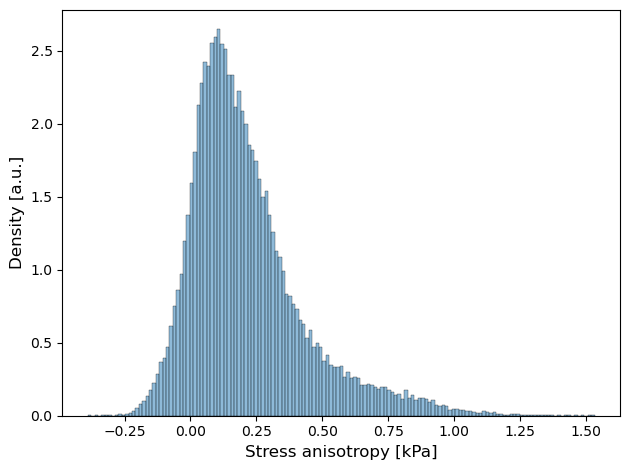

In [33]:
fig, ax = plt.subplots()
sns.histplot(data=df_all_pairs, x='stress_cell_all_pair_anisotropy', ax=ax, stat='density',
             alpha=0.5)
ax.set_xlabel("Stress anisotropy [kPa]", fontsize=12)
ax.set_ylabel("Density [a.u.]", fontsize=12)

fig.tight_layout()
fig.savefig(os.path.join(figure_directory, 'spatial_autocorrelation_all_pair_anisotropy'), dpi=300)

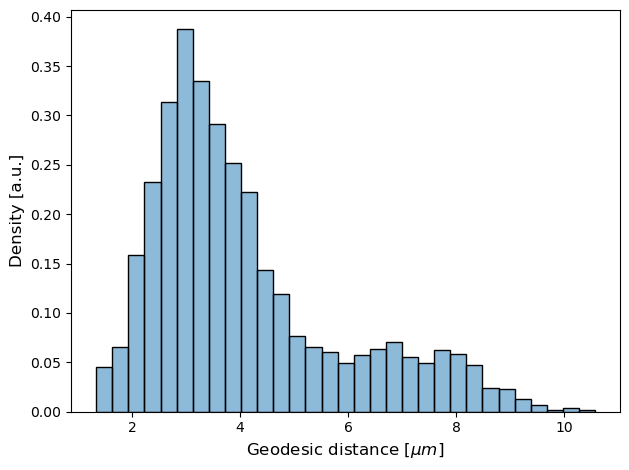

In [34]:
fig, ax = plt.subplots()
sns.histplot(data=df_nearest_pairs, x='stress_cell_nearest_pair_distance', ax=ax, stat='density',
             alpha=0.5)
ax.set_xlabel("Geodesic distance [$\mu m$]", fontsize=12)
ax.set_ylabel("Density [a.u.]", fontsize=12)

fig.tight_layout()
fig.savefig(os.path.join(figure_directory, 'spatial_autocorrelation_nearest_pair_distance'), dpi=300)

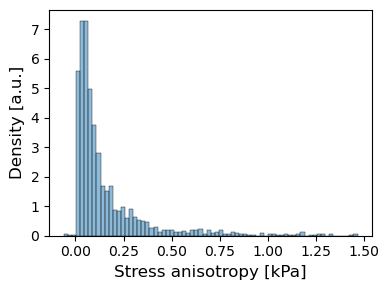

In [35]:
fig, ax = plt.subplots(figsize=(4, 3))
sns.histplot(data=df_nearest_pairs, x='stress_cell_nearest_pair_anisotropy', ax=ax, stat='density',
             alpha=0.5)
ax.set_xlabel("Stress anisotropy [kPa]", fontsize=12)
ax.set_ylabel("Density [a.u.]", fontsize=12)

fig.tight_layout()
fig.savefig(os.path.join(figure_directory, 'spatial_autocorrelation_nearest_pair_anisotropy'), dpi=300)

## Temporal autocorrelations

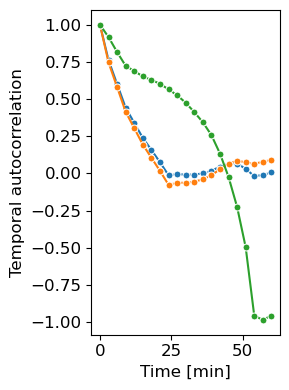

In [36]:
fig, ax = plt.subplots(figsize=(3, 4))
sns.lineplot(df_over_time, x='time', y='autocorrelations_temporal_total', ax=ax, marker='o', markersize=5)
sns.lineplot(df_over_time, x='time', y='autocorrelations_temporal_cell', ax=ax, marker='o', markersize=5)
sns.lineplot(df_over_time, x='time', y='autocorrelations_temporal_tissue', ax=ax, marker='o', markersize=5)

ax.set_xlabel("Time [min]", fontsize=12)
ax.set_ylabel("Temporal autocorrelation", fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=12)

fig.tight_layout()
fig.savefig(os.path.join(figure_directory, 'temporal_autocorrelation_all'), dpi=300, bbox_inches='tight')

## Quantitative comparison

We now compare some of these results quantitatively with the results from the legacy-STRESS code.

In [37]:
df_STRESS = pd.DataFrame()
for file in os.listdir('./results_STRESS/'):
    # read from file with data stored in row direction
    single_result = pd.read_csv(f'./results_STRESS/{file}', header=None).T

    column_name = file.split('.')[0]
    df_STRESS[column_name] = single_result.values.flatten()

Mean absolute difference for stress_total_anisotropy: 0.016833452189876284 $\pm$ 0.02383237024901802
Mean relative difference for stress_total_anisotropy: 0.04419197384167061 $\pm$ 0.04082662114569283
Mean absolute difference for stress_cell_anisotropy: 0.012910974712970943 $\pm$ 0.023923725205633167
Mean relative difference for stress_cell_anisotropy: 0.04517488479277137 $\pm$ 0.038505996101575485
Mean absolute difference for stress_tissue_anisotropy: 0.008447799690334469 $\pm$ 0.0033931168068717893
Mean relative difference for stress_tissue_anisotropy: 0.04213780139826338 $\pm$ 0.015592248911068285


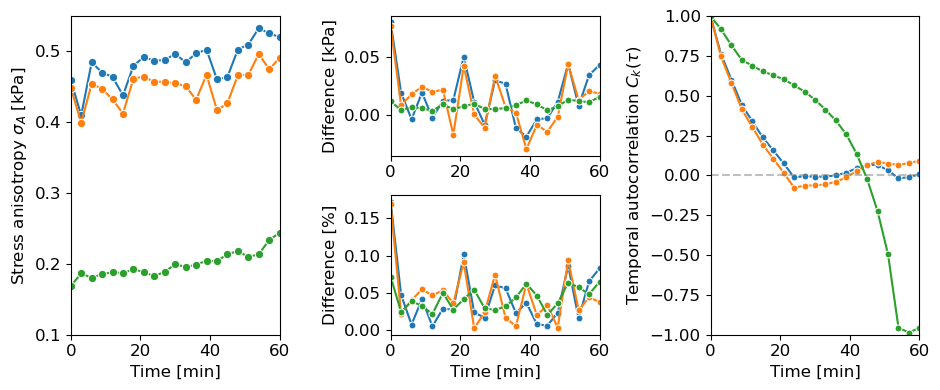

In [41]:
to_compare = ['stress_total_anisotropy', 'stress_cell_anisotropy', 'stress_tissue_anisotropy']
fig = plt.figure(figsize=(9.5, 4))
ax_l = fig.add_subplot(131)
ax_ctop = fig.add_subplot(232)
ax_cbottom = fig.add_subplot(235, sharex=ax_ctop)
ax_r = fig.add_subplot(133)

# stress anisotropies
sns.lineplot(data=df_over_time, x='time', y='stress_total_anisotropy', ax=ax_l,
             markers=True, dashes=False, marker='o')
sns.lineplot(data=df_over_time, x='time', y='stress_cell_anisotropy', ax=ax_l,
             markers=True, dashes=False, marker='o')
sns.lineplot(data=df_over_time, x='time', y='stress_tissue_anisotropy', ax=ax_l,
             markers=True, dashes=False, marker='o')

ax_l.set_xlim([0,  max_time])
ax_l.set_xlabel("Time [min]", fontsize=12)
ax_l.set_ylim(ylims_stress)
ax_l.set_ylabel(r"Stress anisotropy $\sigma_A$ [kPa]", fontsize=12)

# Differences
for item in to_compare:
    difference_absolute = df_STRESS[item] - df_over_time[item]
    difference_relative = np.abs(difference_absolute) / df_over_time[item]

    print(f"Mean absolute difference for {item}: {difference_absolute.mean()} $\pm$ {difference_absolute.std()}")
    print(f"Mean relative difference for {item}: {difference_relative.mean()} $\pm$ {difference_relative.std()}")
    
    sns.lineplot(y=difference_absolute, x=df_over_time['time'], ax=ax_ctop, marker='o', markersize=5)
    ax_ctop.set_ylabel('Difference [kPa]', fontsize=12)
    ax_ctop.set_xlabel('', fontsize=12)

    sns.lineplot(y=difference_relative, x=df_over_time['time'], ax=ax_cbottom, marker='o', markersize=5)
    ax_cbottom.set_ylabel('Difference [%]', fontsize=12)
    ax_cbottom.set_xlabel('Time [min]', fontsize=12)
    fig.tight_layout()

# temporal autocorrelations
sns.lineplot(df_over_time, x='time', y='autocorrelations_temporal_total', ax=ax_r, marker='o', markersize=5)
sns.lineplot(df_over_time, x='time', y='autocorrelations_temporal_cell', ax=ax_r, marker='o', markersize=5)
sns.lineplot(df_over_time, x='time', y='autocorrelations_temporal_tissue', ax=ax_r, marker='o', markersize=5)
ax_r.hlines(0, 0, max_time, linestyle='--', color='gray', alpha=0.5)

ax_r.set_xlabel("Time [min]", fontsize=12)
ax_r.set_ylabel(r"Temporal autocorrelation $C_k(\tau)$", fontsize=12)
ax_r.tick_params(axis='both', which='major', labelsize=12)
ax_r.set_ylim([-1,  1])

fig.align_ylabels([ax_ctop, ax_cbottom])

for ax in [ax_l, ax_ctop, ax_cbottom, ax_r]:
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.set_xlim([0, max_time])
    
fig.tight_layout()

fig.savefig(os.path.join(figure_directory, 'anisotropic_stresses_values_and_differences.png'), dpi=300, bbox_inches='tight')

In [40]:
difference_absolute.mean()

0.008447799690334469